In [1]:
import pandas as pd
import numpy as np
import os
import re
import GPy
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
# from itertools import chain
import random

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Some helper functions, normalization etc

In [2]:
def normalization(a):
    return (a - a.min(axis = 0))/(a.max(axis = 0) - a.min(axis = 0)), a.max(axis = 0), a.min(axis = 0)

def normalization_with_inputs(a, amax, amin):
    return (a - amin)/(amax - amin)

def reverse_normalization(a,amax,amin):
    return a*(amax-amin) + amin

def data_processing(df, name):
    temp = df[name]
    temp = np.array(temp)
    temp = np.reshape(temp, (temp.shape[0],1))
    return temp

def flat(list_2D):
    flatten_list = list(chain.from_iterable(list_2D))
    flatten_list = np.array(flatten_list)
    return flatten_list


# Data loading and model training

In [3]:
dataframe =  pd.read_excel('data.xlsx')
nr_of_samples = 279 # can be used to take only a subset of the data (no special strategy)

V = data_processing(dataframe,'V_bias')[:nr_of_samples]
c_bulk = data_processing(dataframe,'c_bulk')[:nr_of_samples]
c_max = data_processing(dataframe,'c_max')[:nr_of_samples]
epsr = data_processing(dataframe,'epsr')[:nr_of_samples]
max_bulk = data_processing(dataframe,'c_max/c_bulk')[:nr_of_samples]

pscl = data_processing(dataframe, 'd_pscl')[:nr_of_samples]
nscl = data_processing(dataframe, 'd_nscl')[:nr_of_samples]
ratio_v = data_processing(dataframe, 'V_bulk/V_bias')[:nr_of_samples]
ratio_d = data_processing(dataframe, 'd_nscl/d_pscl')[:nr_of_samples]

print(nscl.shape)

X_ratio = np.hstack((c_bulk, c_max, epsr,max_bulk,V))
X_ratio, Xmax_ratio, Xmin_ratio = normalization(X_ratio)

X_layer = np.hstack((c_bulk, c_max, epsr,max_bulk,V))
X_layer, Xmax_layer, Xmin_layer = normalization(X_layer)

ratio_v, max_v, min_v = normalization(ratio_v)
ratio_d, max_d, min_d = normalization(ratio_d)
pscl, p_max, p_min = normalization(pscl)
nscl, n_max, n_min = normalization(nscl)


kernel_ratio_v = GPy.kern.MLP(X_ratio.shape[1],ARD = True)
kernel_ratio_d = GPy.kern.MLP(X_ratio.shape[1],ARD = True)
kernel_layer_n = GPy.kern.MLP(X_layer.shape[1],ARD = True)
kernel_layer_p = GPy.kern.MLP(X_layer.shape[1],ARD = True)

model_ratio_v = GPy.models.GPRegression(X_ratio,ratio_v,kernel_ratio_v) 
model_ratio_d = GPy.models.GPRegression(X_ratio,ratio_d,kernel_ratio_d) 
model_layer_n = GPy.models.GPRegression(X_layer,nscl,kernel_layer_n) 
model_layer_p = GPy.models.GPRegression(X_layer,pscl,kernel_layer_p) 

model_ratio_v.optimize()
model_ratio_d.optimize()
model_layer_n.optimize()
model_layer_p.optimize()




(279, 1)


# Defining the Baseline

In [4]:
#Baseline Data processing

nscl_target = [5,7,8,9,10]
nscl_target = np.array(nscl_target)
nscl_target = np.reshape(nscl_target,(nscl_target.shape[0],1))
nscl_target = normalization_with_inputs(nscl_target, n_max, n_min)

# Find best observation so far according to the model

In [5]:
V_series = np.array([0.5,1.5,2.5,3.5,4.5])
V_normalized = np.array(normalization_with_inputs(V_series, V.max(), V.min()))

def objective_function(Xsamples,model,thickness_current, Voltage):
        Xsamples_2 = Xsamples.copy()
        temp = Voltage * np.ones((Xsamples_2.shape[0],Xsamples_2.shape[1]+1))
        temp[:,:-1] = Xsamples_2
        Xsamples = temp
        del Xsamples_2 
        mu, sigma = model.predict(Xsamples)
        mu = abs(mu)
        mu = np.reshape(mu, (mu.shape[0],1))
        mu = np.reshape(mu, (mu.shape[0],1))
        mu_2 = abs(mu-thickness_current)/abs(thickness_current)
        sigma = np.sqrt(sigma)/abs(thickness_current)
        return mu_2 ,sigma
    
def unique_by_first(a):
    seen = set()
    newlist = []
    for item in a:
        t = tuple(item)
        if t not in seen:
            newlist.append(item)
            seen.add(t)
    return np.array(list(seen))


X_kmc = (unique_by_first(X_layer[:,:-1]))
total_mu_kmc = 0
         
for i in range(V_normalized.shape[0]):
        mu_kmc, _ = objective_function(X_kmc,model_layer_n,nscl_target[i], V_normalized[i])
        total_mu_kmc += -mu_kmc
best_kmc = np.max(total_mu_kmc)

print(best_kmc)
print(X_kmc.shape)


-1.6757808411925836
(55, 4)


# Define BO. Acquisition functions included : Expected Improvement, Probability of Improvement, UCB

In [6]:
def expected_improvement(Xsamples,  model, V_normalized, thickness_target ,sample_best, tradeoff=0.01):
    total_sigma = 0
    total_mu = 0
    for i in range(V_normalized.shape[0]):
        mu_2, sigma = objective_function(Xsamples,model,thickness_target[i], V_normalized[i])
        total_mu += -mu_2
        total_sigma += sigma/V_normalized.shape[0]
        
    total_mu = np.reshape(total_mu, (total_mu.shape[0],1))
    mu_sample_opt = sample_best
    
    with np.errstate(divide='warn'):
        imp = total_mu - mu_sample_opt - tradeoff
        Z = imp / total_sigma
        ei = imp * norm.cdf(Z) + total_sigma * norm.pdf(Z)
        ei[total_sigma == 0.0] = 0.0
    return ei



def probability_improvement(Xsamples, model, V_normalized, thickness_target,sample_best):
    
    total_sigma = 0
    total_mu = 0
    results = []
    Xsamples_2 = Xsamples.copy()
    for i in range(V_normalized.shape[0]):
        mu_2, sigma = objective_function(Xsamples,model,thickness_target[i], V_normalized[i])
        total_mu += -mu_2
        total_sigma += sigma/V_normalized.shape[0]
    total_mu = np.reshape(total_mu, (total_mu.shape[0],1))
    total_mu, ma, mi = normalization(total_mu)
    total_sigma = normalization_with_inputs(total_sigma, ma, mi)
    mu_sample_opt = sample_best
#     mu_sample_opt = normalization_with_inputs(sample_best, ma, mi)

    scores = norm.cdf((total_mu - mu_sample_opt) / (total_sigma+1E-9))
    return scores

def ucb(Xsamples,model, V_normalized, thickness_target, tradeoff = 0.1):
        total_sigma = 0
        total_mu = 0
    
        for i in range(V_normalized.shape[0]):
            mu_2, sigma = objective_function(Xsamples,model,thickness_target[i], V_normalized[i])
            total_mu += -mu_2
            total_sigma += sigma/V_normalized.shape[0]

        return total_mu + tradeoff*total_sigma
        
    
def acquisition(Xsamples, model,  V_normalized, thickness_target ,sample_best,method = "pe" ,tradeoff = 0.01 ):
    if method == "pi":
        scores = probability_improvement(Xsamples,model,V_normalized, thickness_target,sample_best)
    elif method == 'ucb':
        scores = ucb(Xsamples,model, V_normalized, thickness_target, tradeoff)
    elif method == "pe":
        scores = expected_improvement(Xsamples,  model,V_normalized, thickness_target,sample_best, tradeoff)  

    return scores


def opt_acquisition(model, norm_max, norm_min,V_normalized, thickness_target,sample_best, method = "pe",tradeoff = 0.01):
    Xsamples = []
    sample_size = 100000
    

    
    c_bulk = np.random.uniform(low= 1e19, high= 2e20, size=(sample_size,1))
    c_max = np.random.uniform(low= 1.25*c_bulk, high= 5*c_bulk, size=(sample_size,1))
    epsr = np.random.uniform(low= 10, high= 200, size=(sample_size,1))

    Xsamples = np.array(np.hstack((c_bulk, c_max, epsr, c_max/c_bulk)))
    Xsamples = normalization_with_inputs(Xsamples,norm_max,norm_min)


    scores = acquisition(Xsamples, model,V_normalized,thickness_target,sample_best,method, tradeoff)
    ix = np.argmax(scores)
    iy = np.argmin(scores)

    return Xsamples[ix], scores[ix]

# Generate BO suggestions

In [7]:

normalization_flag = True

tradeoff = 0.5   # exploration -  exploitation parameter

method = 'pe'
pi_inputs, scores = opt_acquisition(model_layer_n,Xmax_layer[0:-1], Xmin_layer[0:-1],V_normalized,nscl_target,best_kmc,method, tradeoff)
pi_inputs = np.reshape(pi_inputs, (1,pi_inputs.shape[0]))
# pi_inputs = pi_inputs.T
pi_inputs_unnorm = reverse_normalization(pi_inputs,Xmax_layer[0:-1], Xmin_layer[0:-1])
print(method, pi_inputs_unnorm)
print(scores)

for i in V_normalized:
    test = np.c_[pi_inputs, [i]]
    p , s = model_layer_n.predict(test)
    if normalization_flag:
        p = reverse_normalization(p, n_max, n_min)
        s = reverse_normalization(s, n_max, n_min)
    print(p,np.sqrt(s))



pe [[3.47899358e+19 1.73788445e+20 1.99550509e+02 4.99536549e+00]]
[87.72931873]
[[0.68458644]] [[14.61105056]]
[[3.36794839]] [[14.60849037]]
[[6.04443142]] [[14.60602268]]
[[8.71389555]] [[14.60364743]]
[[11.37620212]] [[14.60136458]]


In [8]:
class physical_investigation():
    def __init__(self, model, quantity_max,quantity_min,input_max,input_min, limit = 1, name = 'default'):
        self.model = model
        self.quantity_max = quantity_max
        self.quantity_min = quantity_min
        self.input_max = input_max
        self.input_min = input_min
        self.property_name = name
        self.limit = limit
        
    def point_creation(self , size = 300):
#         self.lim_1 , self.lim_2 = np.log10(5e17),20
        self.lim_1 , self.lim_2 =17,20

        self.c_bulk = np.zeros((size, size))
        self.c_max = np.zeros((size, size))
        voltage = []
        self.voltage_value = 2.5
        
        x_bulk_in = np.logspace(self.lim_1,self.lim_2,size) 
        for i in range(size):
            self.c_bulk[i,:] = x_bulk_in[i]
    
        coef = np.linspace(1.25,10,size)
        self.coef_2d = np.zeros((size,size))
        for i in range(size):
            for j in range(size):
                self.c_max[i,j] = self.c_bulk[i,j]*coef[j]
                self.coef_2d[i,j] = coef[j]
                
    def predictions(self,epsr_value = 100, size = 300, V = 2.5):
        self.epsr_value = epsr_value
        self.point_creation(size)
        self.colourmp_prediction = np.zeros((size,size))
        self.colourmp_variance = np.zeros((size,size))
        self.variance_metric = np.zeros((size,size))
        for i in range(size):
            for j in range(size):

                temp = np.array([[self.c_bulk[i,j],self.c_max[i,j],self.epsr_value,self.c_max[i,j]/self.c_bulk[i,j],V]])
                temp = normalization_with_inputs(temp, self.input_max, self.input_min)

                mean_pl, variance_pl = self.model.predict(temp)
                mean_pl = np.maximum(reverse_normalization(mean_pl, self.quantity_max, self.quantity_min),self.limit)# 1 is the minimum kMC discretization size
#                 variance_pl = abs(reverse_normalization(variance_pl, self.quantity_max, self.quantity_min))
                
                self.colourmp_prediction[i, j] = mean_pl  
                self.colourmp_variance[i, j] = np.sqrt((variance_pl))
                self.variance_metric[i, j] = (np.sqrt( (variance_pl)))/ np.maximum(mean_pl,self.limit)
                
    def visualization(self):
        
        plt.contourf(np.log10(self.c_bulk),self.coef_2d, self.colourmp_prediction)
        plt.title('epsr = '+ str(self.epsr_value))
        plt.colorbar(location = 'right', label = self.property_name )
        plt.xlabel('Concentration cbulk ($cm^3$)')
        plt.ylabel('Concentration cmax(cbulk)')
        plt.show()

        plt.contourf(np.log10(self.c_bulk),self.coef_2d, self.variance_metric)
        plt.title('epsr = '  + str(self.epsr_value))
        plt.colorbar(location = 'right', label = 'variance of ' + self.property_name)
        plt.xlabel('Concentration cbulk ($cm^3$)')
        plt.ylabel('Concentration cmax(cbulk)')
        plt.show()
    
    def data_saving(self):
        
        list_of_tuples = list(zip(flat(self.c_bulk),flat(self.c_max), flat(self.colourmp_prediction),flat(self.colourmp_variance),flat(self.variance_metric)))
        df = pd.DataFrame(list_of_tuples, columns=['c_bulk','c_max', 'ratio', 'std', 'std_metric'])
        df.to_csv('3d_plot_'+self.property_name+'_' + str(self.epsr_value)+'.txt', sep ='\t')




In [13]:
suffix = '_full_correct_variance'

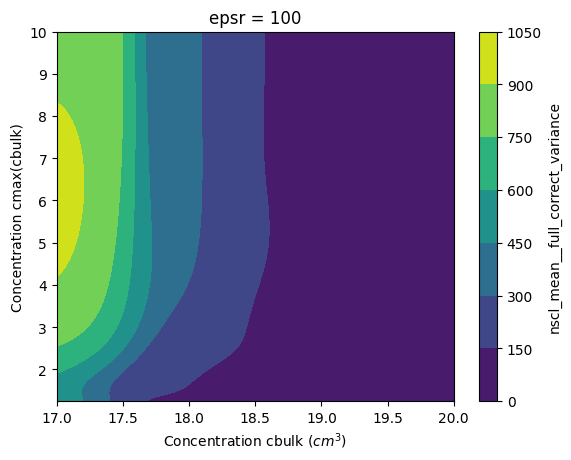

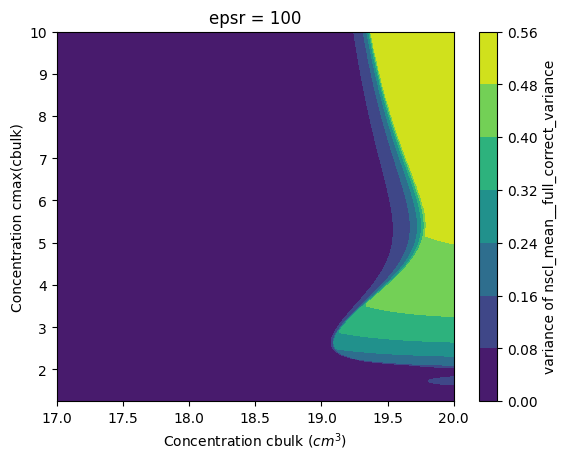

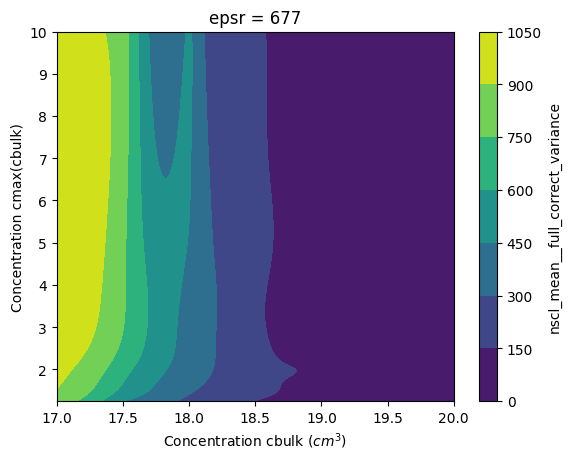

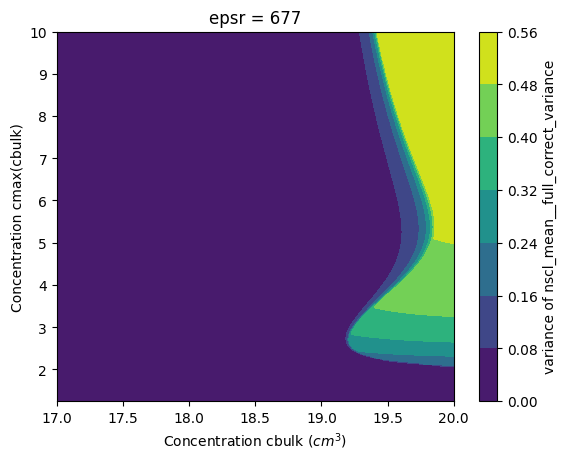

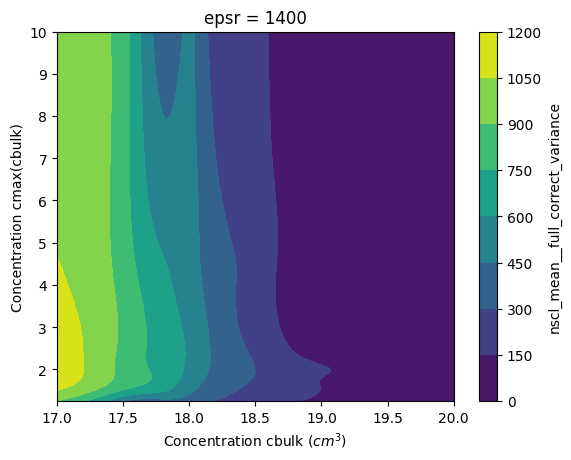

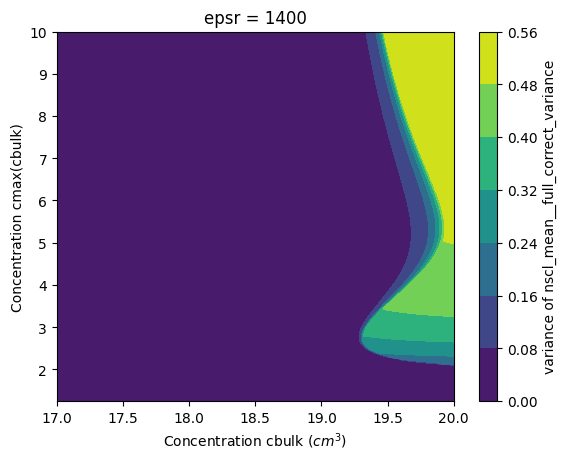

In [14]:


for epsr in [100, 677,1400]:
    nscl_inv = physical_investigation(model_layer_n,n_max, n_min,Xmax_layer, Xmin_layer,1, 'nscl_mean_'+suffix)
    nscl_inv.predictions(epsr_value = epsr, size = 300)
    nscl_inv.visualization()
#     nscl_inv.data_saving()

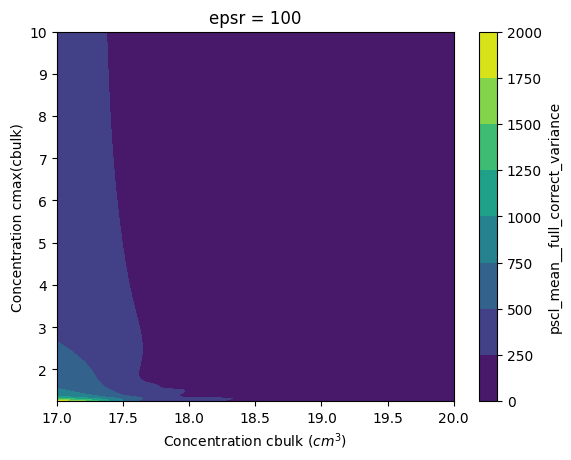

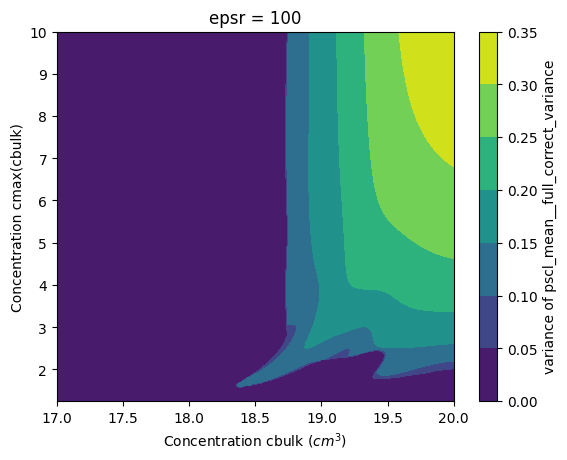

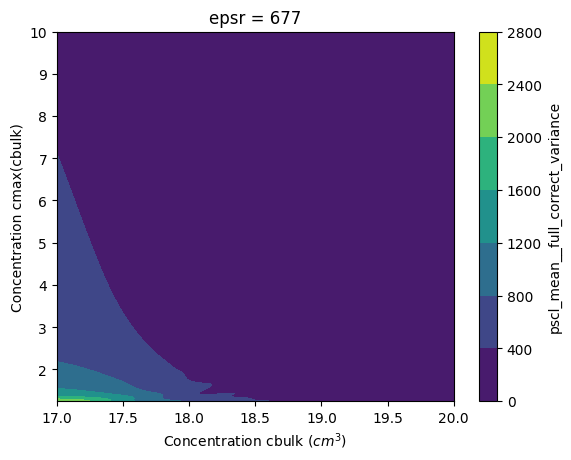

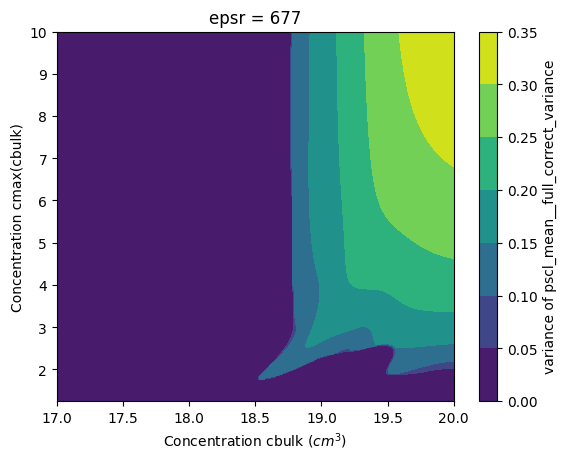

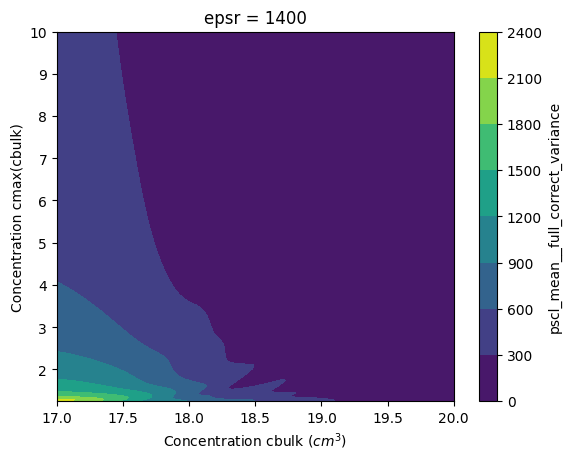

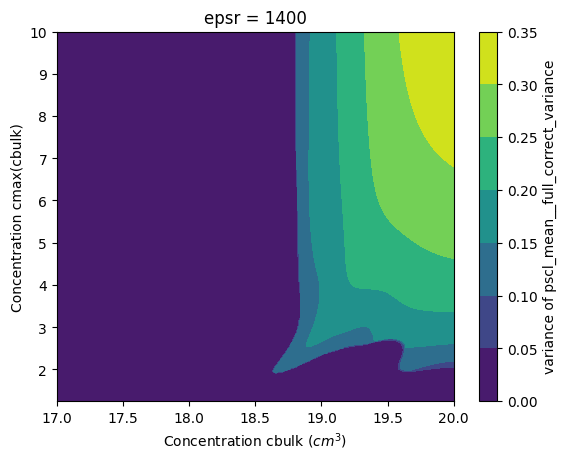

In [15]:
for epsr in [100, 677,1400]:
    pscl_inv = physical_investigation(model_layer_p,p_max, p_min, Xmax_layer, Xmin_layer,1, 'pscl_mean_'+suffix)
    pscl_inv.predictions(epsr_value = epsr, size = 300)
    pscl_inv.visualization()
#     pscl_inv.data_saving()

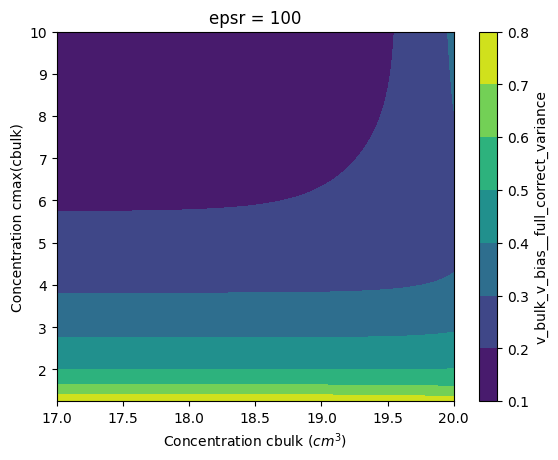

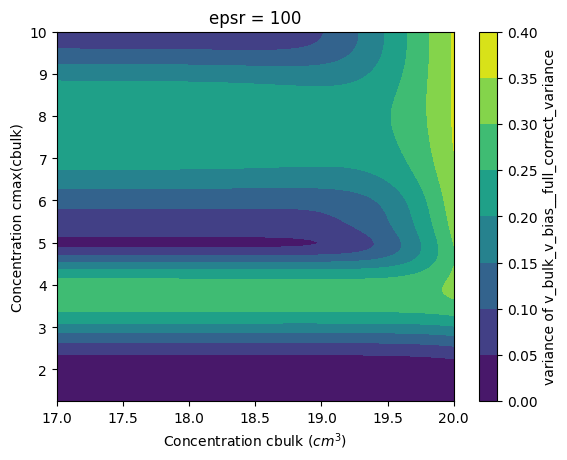

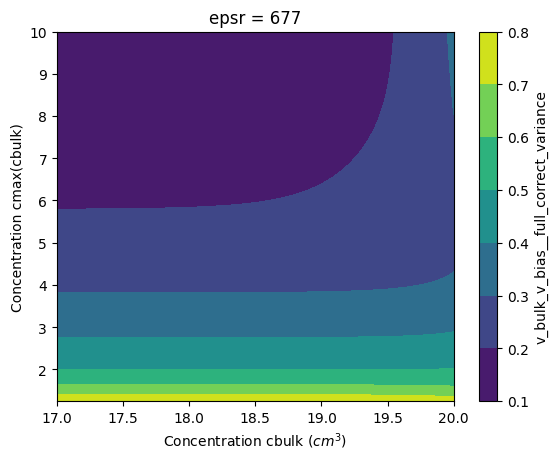

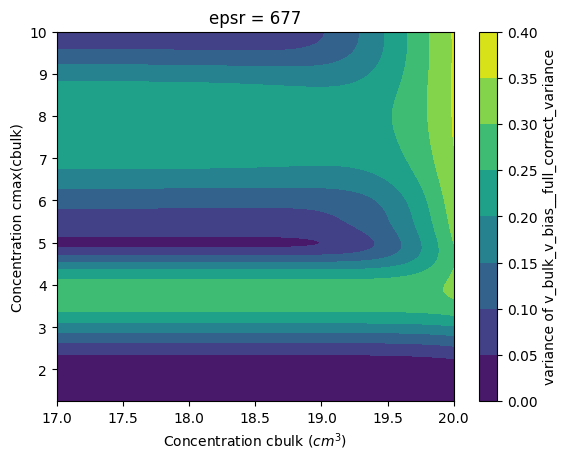

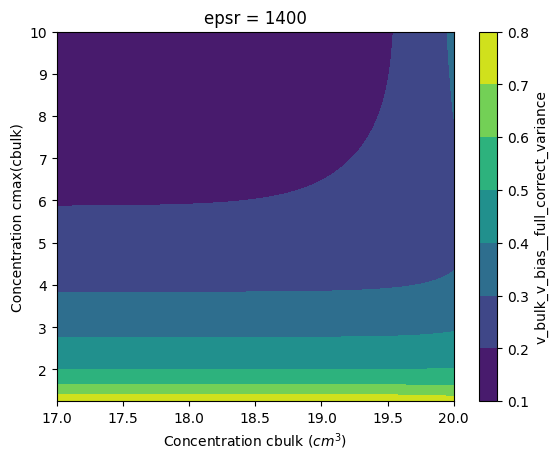

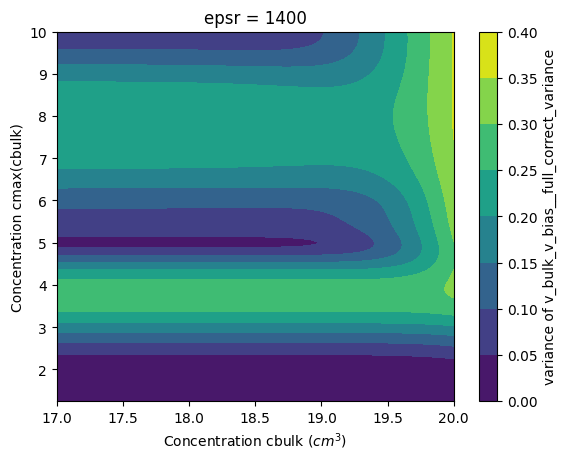

In [16]:
for epsr in [100, 677,1400]:
    v_ratio_inv = physical_investigation(model_ratio_v,max_v, min_v,Xmax_ratio, Xmin_ratio,0, 'v_bulk_v_bias_'+suffix)
    v_ratio_inv.predictions(epsr_value = epsr, size = 300)
    v_ratio_inv.visualization()
#     v_ratio_inv.data_saving()

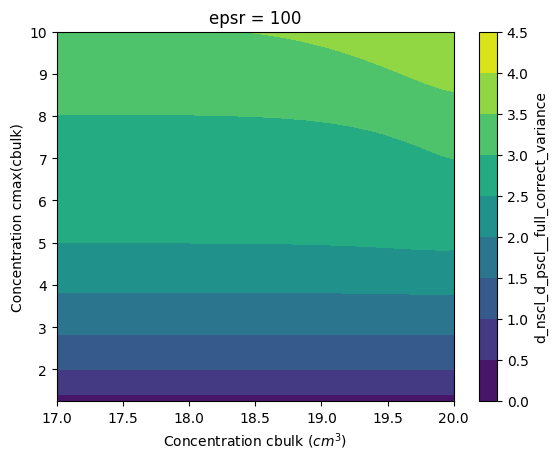

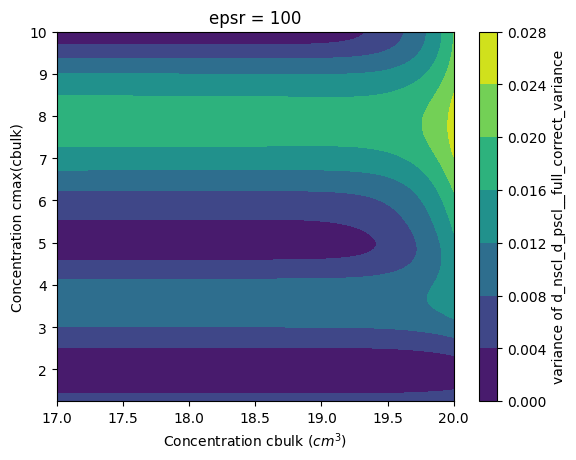

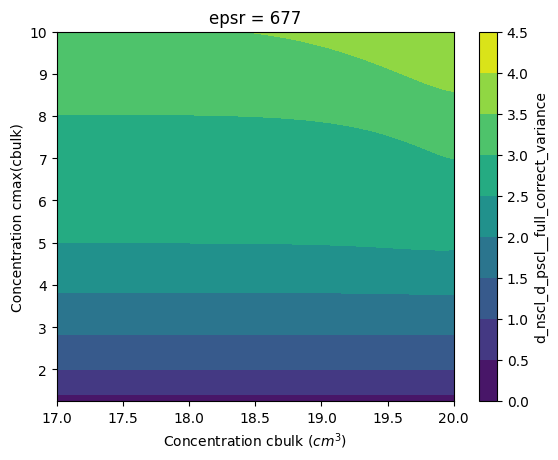

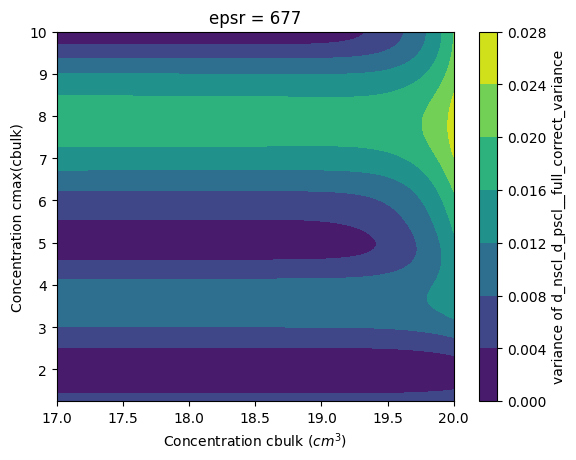

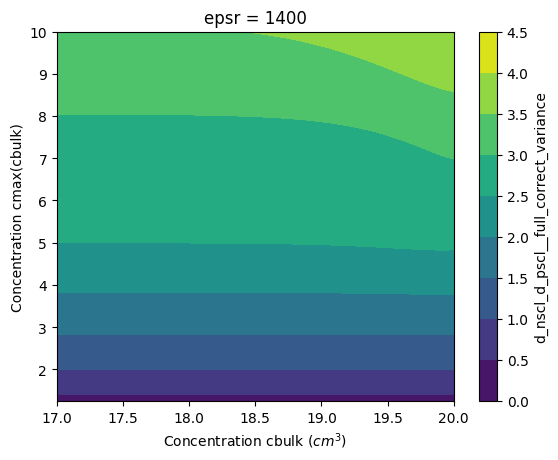

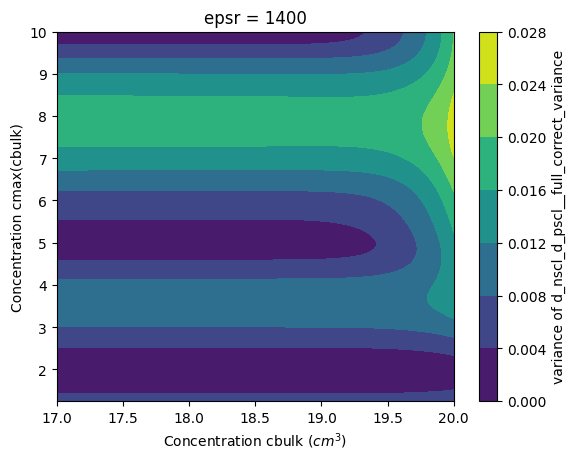

In [17]:
for epsr in [100, 677,1400]:
    d_ratio_inv = physical_investigation(model_ratio_d,max_d, min_d,Xmax_ratio, Xmin_ratio,0, 'd_nscl_d_pscl_'+suffix)
    d_ratio_inv.predictions(epsr_value = epsr, size = 300)
    d_ratio_inv.visualization()
#     d_ratio_inv.data_saving()

In [19]:
requirements

[('matplotlib', '3.6.3'),
 ('numpy', '1.23.5'),
 ('GPy', '1.10.0'),
 ('pandas', '1.5.3')]